# Book Genre Prediction using machine learning

## prepared by Karol Wesołowski

### Learning task and preparation

The task of the algorithm is to predict a genre of a book based on a blurp. Blurp is a short description of a piece created by publisher, to promote the book and show the general content of it. Genre is usually a broad category used to classify books by sellers.

Data for the task comes from Kaggle and is presented in the form of csv file.

In [1]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC

To perform the task it is required to use many python packages. For machine learning computations I used packages from sklearn family. For text analysis I used nltk package. Data is saved into Panda DataFrame format. Math operation using Numpy, to measure time I used default python time package. Graphs generated using pyplot and Seaborn. To improve computation time, I used Counter from collections package to create "bag of words".

### Data

In [2]:
data = pd.read_csv("data.csv", index_col=0)
print(data.head())

                           title    genre  \
index                                       
0              Drowned Wednesday  fantasy   
1                  The Lost Hero  fantasy   
2      The Eyes of the Overworld  fantasy   
3                Magic's Promise  fantasy   
4                 Taran Wanderer  fantasy   

                                                 summary  
index                                                     
0       Drowned Wednesday is the first Trustee among ...  
1       As the book opens, Jason awakens on a school ...  
2       Cugel is easily persuaded by the merchant Fia...  
3       The book opens with Herald-Mage Vanyel return...  
4       Taran and Gurgi have returned to Caer Dallben...  


Data consist of four columns:
- Index: Integer, not used in computation;
- Title: String, not used in computation;
- Genre: Enum String, proper generation of this field is the goal of the computation
- Summary: long String, blurp content, data used in computation


In [3]:
print("shape of the data frame ", data.shape)
print("does it contains missing values?\n", data.isna().any(), "\n_______")

shape of the data frame  (4657, 3)
does it contains missing values?
 title      False
genre      False
summary    False
dtype: bool 
_______


In [4]:
genres = data.groupby(["genre"])["genre"].count().sort_values(ascending=False)
print(genres)

genre
thriller      1023
fantasy        876
science        647
history        600
horror         600
crime          500
romance        111
psychology     100
sports         100
travel         100
Name: genre, dtype: int64


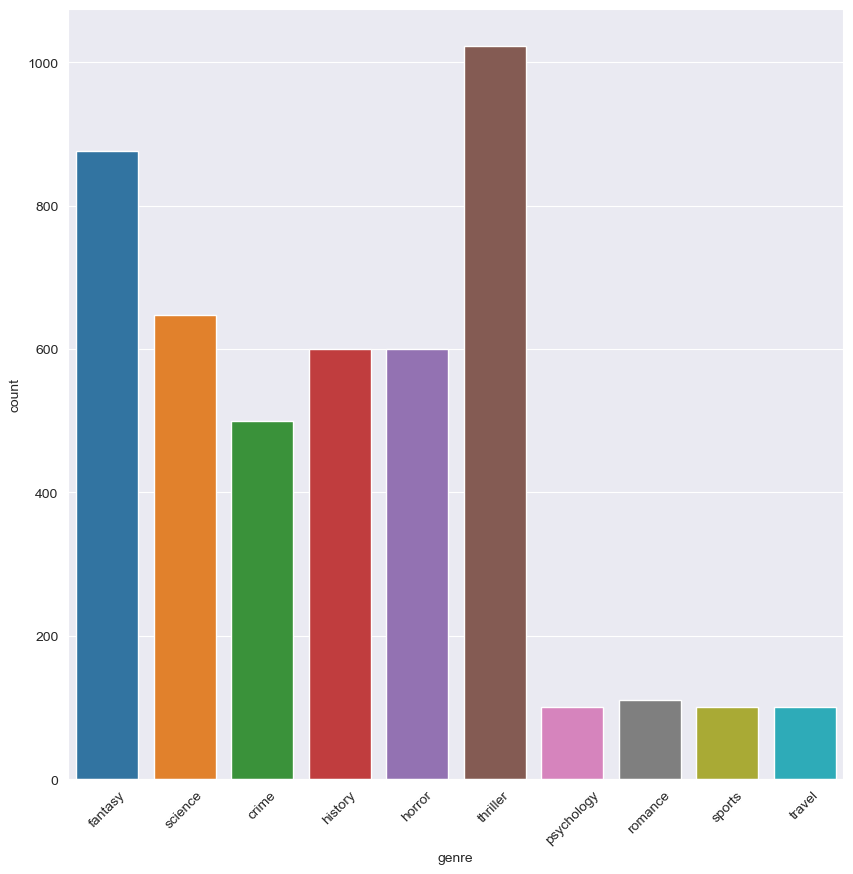

In [5]:
plt.figure(figsize=(10, 10))
g = sns.countplot(x="genre", data=data)
plt.xticks(rotation=45)
fig = g.get_figure()
plt.show()

As seen in the computation output, data contains nearly 4,500 records, split into 10 genre categories. Every record is complete (doesn't contain None values). The most popular genre is "thriller", closely followed by "fantasy". Three genres: "psychology", "sport" and "travel" have 100 records each, which makes them the least popular categories.

For convenience reasons, graph generating code in original file is saved into a function ```graph(data)```, and its output is saved to a png file.

Next step in the computation is to clean the data and prepare it to text analysis. Every summary is sent to ```nlp_cleaning``` function, which performs following steps:
1. turn every word to lower case
2. split words into tokens
3. remove all tokens that are not "words" (e.g. numbers)
4. remove english stopwords downloaded from ```nltk.corpus.stopwords```
5. convert nouns into singular
6. convert verbs into base form
7. create dictionary of tokens and count of their appearance in text

Generated stems (processed tokens) and dictionary are added to 'data' DataFrame as "clean" and "word_dictionary" columns.
Because this function is very slow and time-consuming, its result is saved to csv file, and is meant to run only once. To follow progress it prints a dot ('.') every time it finishes computing.

In [6]:
def nlp_cleaning(data, output_filename):
    english_stops = set(stopwords.words("english"))
    wl = WordNetLemmatizer()
    new_col_stems = []
    new_col_dicts = []
    for summary in data["summary"]:
        print(".", end="")
        tokens = word_tokenize(summary.lower())  # split into tokens
        letters_only = [token for token in tokens if token.isalpha()]  # remove non-alpha
        no_stops = [token for token in letters_only if token not in english_stops]  # remove stop words
        stems = [wl.lemmatize(token) for token in no_stops]  # remove plural forms
        stems = [wl.lemmatize(token, 'v') for token in stems]  # change verbs to base form
        word_dict = Counter(stems)
        new_col_dicts.append(word_dict)
        new_col_stems.append(stems)
    data["clean"] = new_col_stems
    data["word_dictionary"] = new_col_dicts
    data.to_csv(output_filename)

To show the result I am using an excerpt of original data, containing first ten rows.

In [7]:
small = pd.read_csv("small.csv", index_col=0)
nlp_cleaning(small, "small_out.csv")
print("\n", small.head(5))

..........
                            title    genre  \
index                                       
0              Drowned Wednesday  fantasy   
1                  The Lost Hero  fantasy   
2      The Eyes of the Overworld  fantasy   
3                Magic's Promise  fantasy   
4                 Taran Wanderer  fantasy   

                                                 summary  \
index                                                      
0       Drowned Wednesday is the first Trustee among ...   
1       As the book opens, Jason awakens on a school ...   
2       Cugel is easily persuaded by the merchant Fia...   
3       The book opens with Herald-Mage Vanyel return...   
4       Taran and Gurgi have returned to Caer Dallben...   

                                                   clean  \
index                                                      
0      [drown, wednesday, first, trustee, among, morr...   
1      [book, open, jason, awaken, school, bus, unabl...   
2      [cug

Processed data is then reloaded into program.

### Literary Overview

The scientific paper Book Genre Prediction by Priyal Desai et al. suggest using logistic regression to solve the same problem on larger scale. In their implementation they allow a book to belong to many genres, which is how it usually works in real life. Books and movies have traits, that allows them to be considered as parts of many categories, yet there always should be one, that is the most important. It isn't always the most clearly visible genre, and thus the algorithm is not expected to have 100% accuracy.
Because of existence of multiple categories it is best to use One vs Rest classifier.
Authors of the paper also suggested, that using unsupervised learning technics may provide better results and can be considered more useful, due to its ability to work with raw data. But because I have a dataset with clearly classified records, it is much simpler to use supervised learning methods (which is also the point of the authors - precategorized data is easy to obtain from retailers and publishers)
Other works covering this topic suggest using multiple models and choosing one that creates the best results. That is the way I chose. I took four models: Logistic regression, because it was suggested by the most works, K-nearest neighbours for its simplicity, Multinomial Naive Bayes, due to how good it works with multicategorical data and Support Vector classifier, because it is considered the best for text analysis.

In [37]:
def fit(X_train, X_test, y_train, y_test, old_labels):
    ans = []
    models = [KNeighborsClassifier(), LogisticRegression(), MultinomialNB(), SVC()]
    graph, axes = plt.subplots(len(models)//2, 2, figsize=(18,12))
    graph.suptitle("OneVsRestClassifier")
    graph.tight_layout(pad=5.0)
    for i, model in enumerate(models):
        model = OneVsRestClassifier(model)
        start = time.process_time()
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        fin = time.process_time()
        ac = accuracy_score(pred, y_test)
        f1 = f1_score(pred, y_test, average="macro")

        ans.append([str(model), ac, f1, (fin - start) * 1000])

        cfm = confusion_matrix(y_test, pred)

        # Generate graphs
        plt.figure(figsize=(10, 10))
        fig = sns.heatmap(cfm / cfm.sum(axis=1)[:, None] * 100, annot=True, cmap='Greens', vmax=100)
        fig.set_title(str(model) + "[%]")
        fig.set_xlabel("Predicted")
        fig.set_ylabel("Real")
        plt.xticks(rotation=45)
        plt.yticks(rotation=45)
        fig.xaxis.set_ticklabels(old_labels)
        fig.yaxis.set_ticklabels(old_labels)
        fig = fig.get_figure()
        fig.savefig(str(model) + ".png")
        fig = sns.heatmap(cfm / cfm.sum(axis=1)[:, None] * 100, ax=axes[i//2, i%2], annot=True, cmap='Greens', vmax=100)
        fig.tick_params(labelrotation=45)
        fig.xaxis.set_ticklabels(old_labels)
        fig.yaxis.set_ticklabels(old_labels)
        title = str(model).split('=')[1][:-3]
        fig.title.set_text(title)

    df = pd.DataFrame(ans, columns=["model", "accuracy", "F1 score", "time ms"])
    graph.savefig("grid.png")
    return df

The main function of the program is called fit. Based on data and a list of models, it creates predictions, calculates accuracy and F1 score and finally presents the result as confusion matrix. Function is executed by the following code:

In [9]:
# Utensils
def string_to_list(s):
    s = s[1:len(s) - 1]
    tmp = s.split()
    ans = []
    for label in tmp:
        ans.append(label[1:len(label) - 2])
    return ans


def sum_counter(data):
    genre = set(data["genre"])
    genre_dict = {g: [] for g in genre}
    genre_dict_counter = {}
    for _, row in data.iterrows():
        genre_dict[row["genre"]].append(Counter(string_to_list(row["clean"])))
    for key in genre_dict.keys():
        genre_dict_counter[key] = sum(genre_dict[key], Counter())
    return genre_dict_counter


def words_dict_by_genre(data):
    dict = sum_counter(data)
    for key in dict.keys():
        print(key + ": " + str(dict[key].most_common(10)))

In [10]:
# Preparation
data = pd.read_csv("out.csv")
words_dict_by_genre(data)
encoder = LabelEncoder()
data["genre"] = encoder.fit_transform(data["genre"])
old_labels = dict(zip(encoder.classes_, range(len(encoder.classes_))))
X_data = CountVectorizer().fit_transform(data["clean"])
X_train, X_test, y_train, y_test = train_test_split(X_data, data["genre"], test_size=0.25, random_state=79)

fantasy: [('find', 1087), ('one', 1017), ('take', 835), ('kill', 655), ('go', 645), ('world', 634), ('time', 615), ('make', 608), ('king', 602), ('life', 601)]
thriller: [('one', 1039), ('find', 1011), ('kill', 811), ('take', 672), ('go', 639), ('life', 621), ('new', 610), ('two', 536), ('murder', 525), ('know', 525)]
sports: [('one', 116), ('l', 99), ('team', 81), ('get', 69), ('life', 68), ('know', 66), ('new', 62), ('player', 57), ('want', 57), ('make', 54)]
science: [('one', 719), ('time', 677), ('human', 599), ('take', 595), ('find', 575), ('world', 539), ('ship', 485), ('planet', 484), ('earth', 458), ('make', 445)]
romance: [('love', 112), ('one', 111), ('l', 111), ('life', 84), ('new', 72), ('know', 67), ('make', 52), ('time', 45), ('find', 42), ('year', 40)]
history: [('take', 808), ('one', 648), ('find', 639), ('father', 582), ('return', 557), ('make', 552), ('become', 519), ('tell', 515), ('go', 508), ('life', 499)]
crime: [('find', 761), ('murder', 709), ('one', 556), ('kil

                                               model  accuracy  F1 score  \
0  OneVsRestClassifier(estimator=KNeighborsClassi...  0.238627  0.180809   
1  OneVsRestClassifier(estimator=LogisticRegressi...  0.660944  0.631467   
2     OneVsRestClassifier(estimator=MultinomialNB())  0.657511  0.457946   
3               OneVsRestClassifier(estimator=SVC())  0.648069  0.616147   

      time ms  
0    4796.875  
1   30046.875  
2     140.625  
3  126843.750  


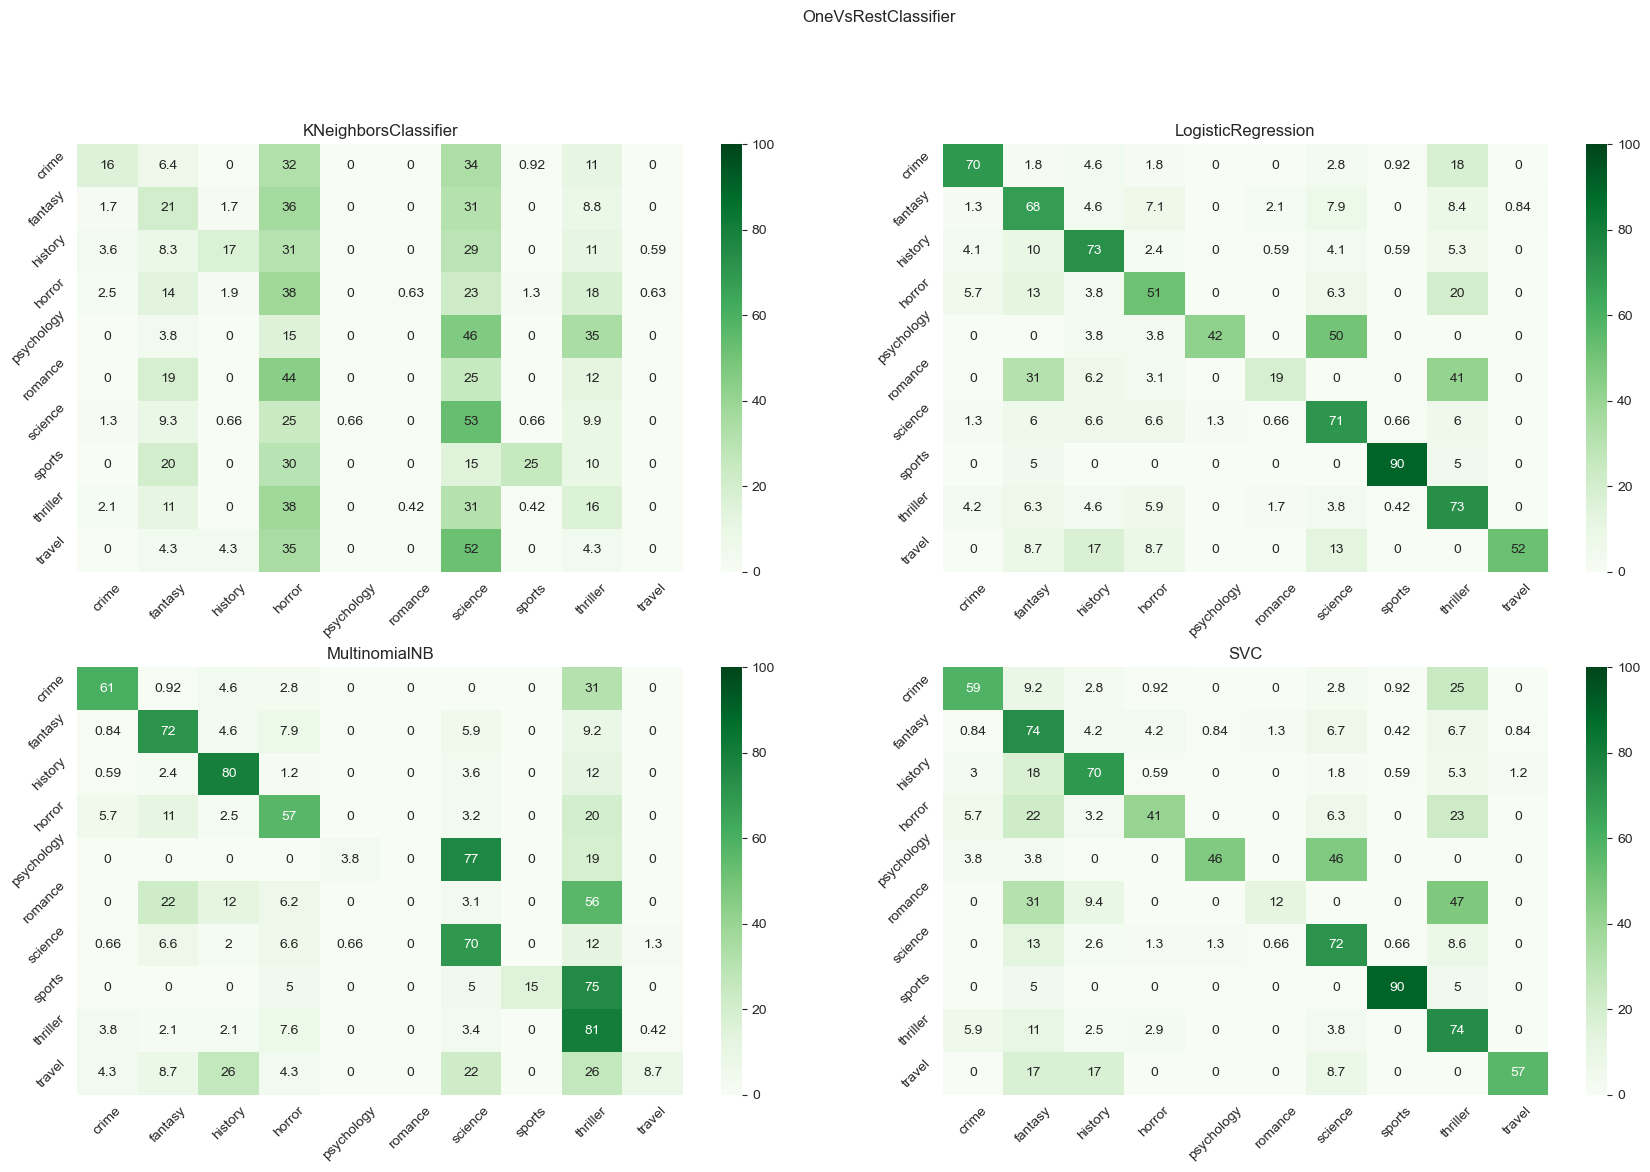

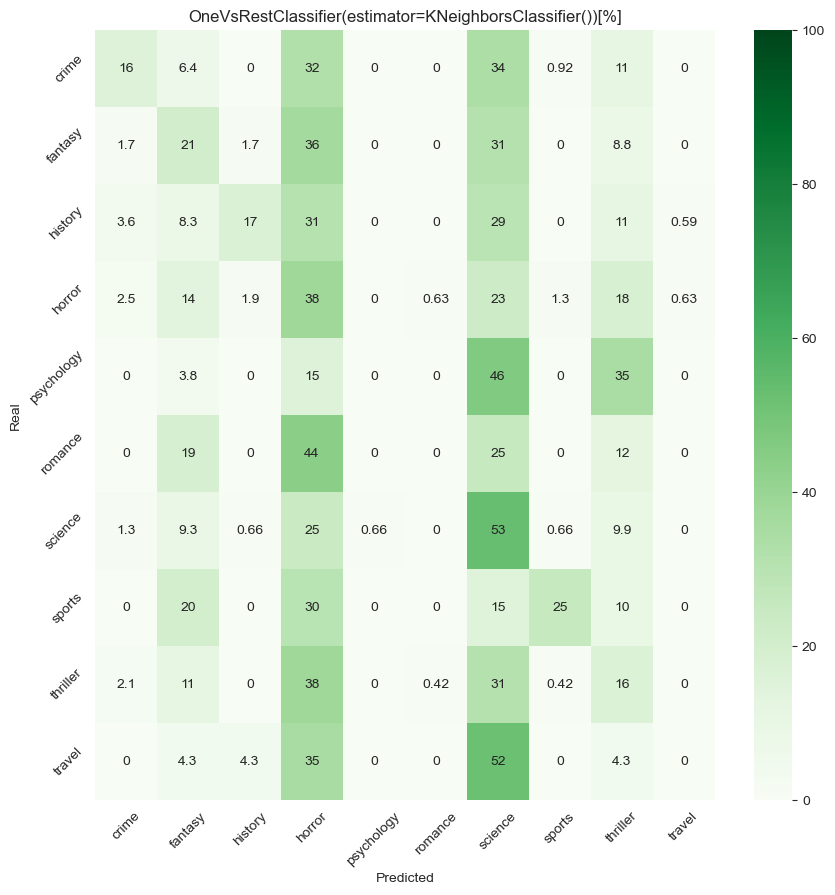

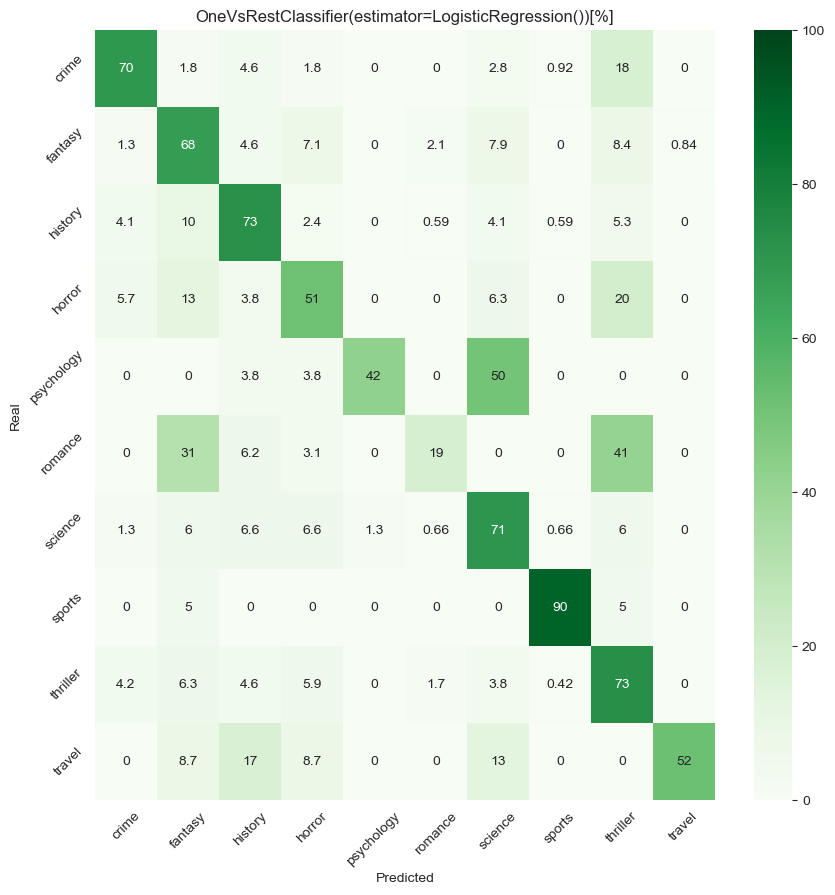

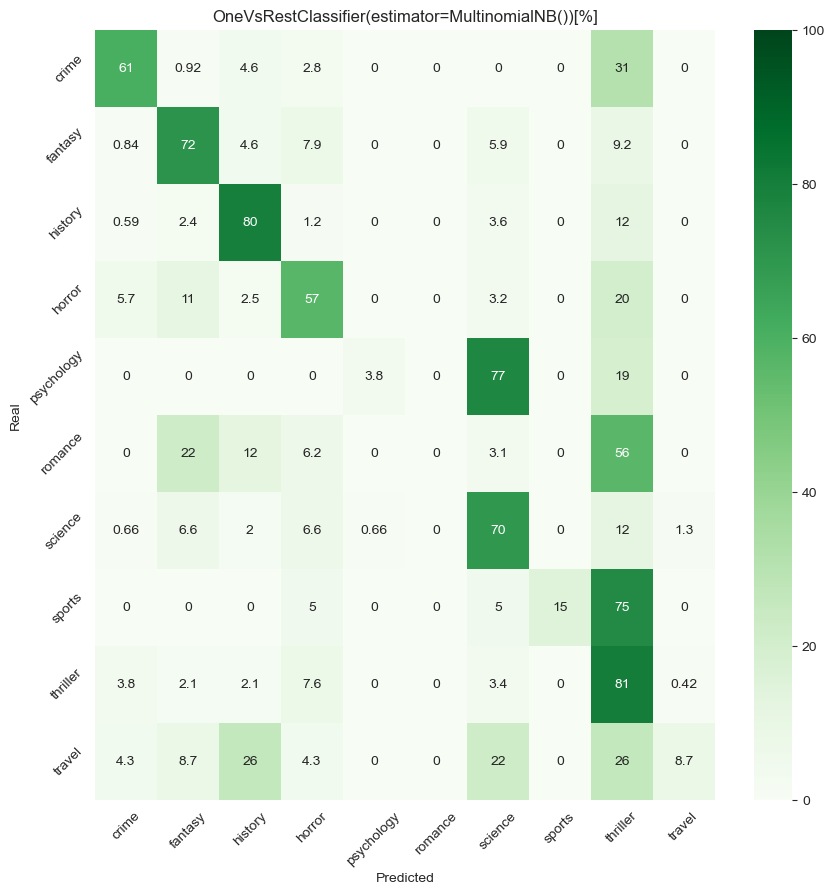

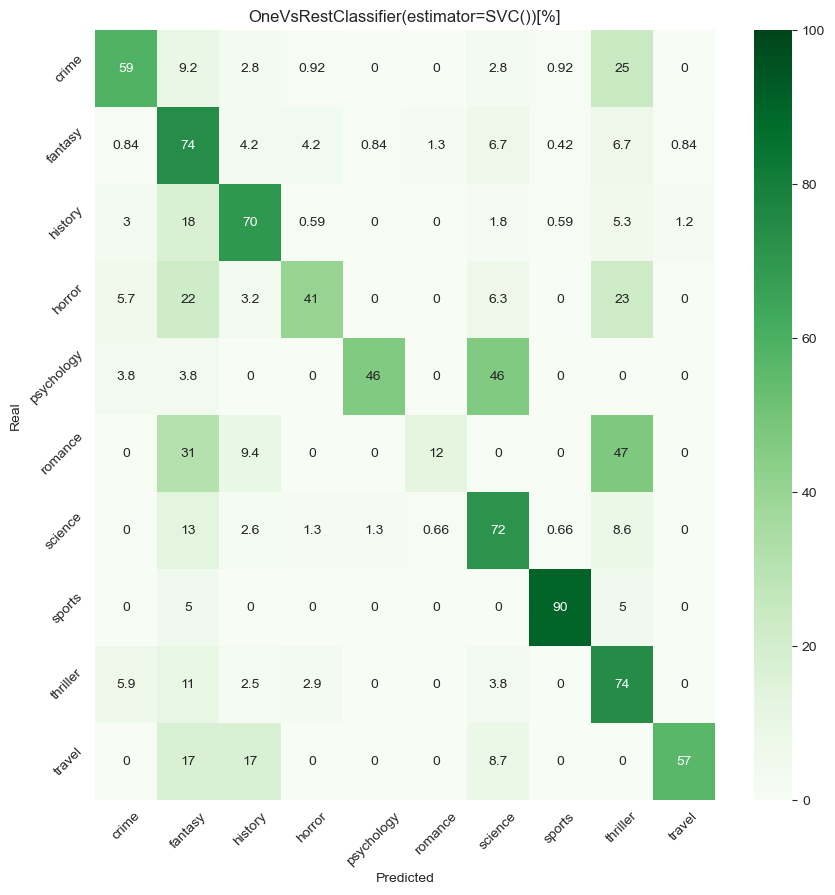

In [38]:
# Execution
df = fit(X_train, X_test, y_train, y_test, old_labels)
print(df)

### Output

Output generated by the functions consist of couple parts. First is the dictionary of most popular tokens in each genre. As can be seen, some of them repeat over many categories (words like 'one', 'take' or 'find'), which may lead (and very likely leads) to confusion and mistakes in classification.

K-nearest Neighbor classifier fails completely, reaching a little more than 20% accuracy. Results are quite random, most of the books got classified either as 'Horror', or as 'Science' (even though less than half of Horror books are classified correctly).
Logistic Regression proved to be the best possible model, with 66% accuracy and F1 score at 0.63. There are some problems, for example with 'Psychology' (but it is a very small genre), 'Romance' (same reason) and 'Horror', which get confused with 'Fantasy' and 'Thriller'. It is not a bad result, considering how closely related those genres are in real life. It is also quite slow model.
Multinomial Naive Bayes is the fastest model in my list, which also generates surprisingly good results. It managed to compute mostly correct results for big categories and failed completely when it came to smaller ones (only 15% of 'Sport' classified correctly, and 0% of 'Romance'). Most not fitting books got classified as 'Thriller' (biggest genre in the dataset), which results in rather low F1 score at 0.45. Probably more balanced dataset would generate more accurate results.
Support Vectors is the slowest model, working 3 times as long as LR and 740 times slower than MNB. Its results are good, little bit worse than those computed using Logistic Regression. Results are pretty identical. Gig groups are classified correctly, 'Romance' proves to be the hardest, 'Psychology' is confused with 'Science [Fiction]' and 'Horror' is mixed with 'Fantasy' and 'Thriller'. Surprisingly sport is predicted with 90% of accuracy, even though it is one of the smallest categories.

In [12]:
def fit_best(X_train, X_test, y_train, y_test):
    ans = []
    for c in range(1,11):
        model = OneVsRestClassifier(LogisticRegression(C=c/10))
        start = time.process_time()
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        fin = time.process_time()
        ac = accuracy_score(pred, y_test)
        f1 = f1_score(pred, y_test, average="macro")
        ans.append([c/10, ac, f1, (fin - start) * 1000])
    df = pd.DataFrame(ans, columns=["c", "accuracy", "F1 score", "time ms"])
    return df

In [13]:
df = fit_best(X_train, X_test, y_train, y_test)
print(df)

     c  accuracy  F1 score    time ms
0  0.1  0.670386  0.633337  20343.750
1  0.2  0.666094  0.636749  22578.125
2  0.3  0.664378  0.635697  23234.375
3  0.4  0.660944  0.633087  25296.875
4  0.5  0.660944  0.630985  26625.000
5  0.6  0.660086  0.630174  28453.125
6  0.7  0.660944  0.630893  28640.625
7  0.8  0.660944  0.631102  30078.125
8  0.9  0.660944  0.631280  28468.750
9  1.0  0.660944  0.631467  30312.500


Taking the Logistic Regression, I manipulated its parameter in an attempt to achieve better results. But the answers are consistent. Difference in accuracy between best (C=0) and worse (C=1, default) attempt is 1%, F1 score differs even less. The higher the value of C parameter (stronger regularisation), the faster the computation, but even here the difference is not that big (8 seconds).

### Summary

As I suspected, reaching 70% accuracy is not possible. The answers I got are good enough, considering the nature of data, and the limitations of dataset. In original form, presented in abovementioned article, problem allows a book to belong to multiple categories. That way it would be possible to limit wrong classification, by simply assigning two genres to one book. In many cases, seen in the graphs above, those double categories would make sense.
In my opinion this program could be useful for retailers, who want to categorize books they sell. It may work better, if the data is more equally distributed. This analysis also proves, that artificial intelligence algorithms are able to recognize a genre of given text, so it would be interesting to see, if they work as good with real text, not only with blurp, whose goal is to inform reader about the interior of th book.
My calculation doesn't take title into consideration. It may improve the results, or may make it worse, considering many titles reflects the content only partly, or in a metaphorical way (Consider "Where crawdads sing", romance/criminal book, whose title may suggest something about biology).